In [1]:
import pandas as pd
import numpy as np 

Okay the goal is to generate causal data on a very small dataset where

A -> B 

A -> C -> D

with the following equation set 

$$ A \sim N(1,1) $$ 
$$ B = A + A^2 + N(0,1) $$ 
$$ C = A^3 + N(0,1) $$ 
$$ D = C^2 + 1 + N(0,1) $$ 

In [2]:
batch = 100
A = np.random.normal(1,1, batch)


In [3]:
def f_b(a): 
    b = a + a**2 + np.random.normal(0,1,1)
    return b

vf_b = np.vectorize(f_b) 

B = vf_b(A)

In [4]:
print(A[0])
print(B[0])
print(A[0] + A[0]**2)
print(B[0] - (A[0] + A[0]**2))


2.020123142166087
5.324086644328226
6.10102065168107
-0.7769340073528443


In [5]:
def f_c(a): 
    c = a**3 + np.random.normal(0,1,1) 
    return c

vf_c = np.vectorize(f_c)

C = vf_c(A)

In [6]:
def f_d(c): 
    d = c**2 + 1 + np.random.normal(0,1,1)
    return d 

vf_d = np.vectorize(f_d)

D = vf_d(C)

In [7]:
data = np.array([A,B,C,D])

In [8]:
data.shape

(4, 100)

In [9]:
data = np.transpose(data)

In [10]:
data.shape

(100, 4)

good now we have the data in observation, feature format 


In [11]:
data[0, :]

array([ 2.02012314,  5.32408664,  7.60440243, 59.55138484])

In [12]:
print(f"A: {A[0]}, B: {B[0]}, C: {C[0]}, D: {D[0]}")

A: 2.020123142166087, B: 5.324086644328226, C: 7.604402429182668, D: 59.55138484217512


great the labels are also correct and as expected 

In [13]:
labels = ["A", "B", "C", "D"]

now lets try to apply the PC algo

  0%|          | 0/4 [00:00<?, ?it/s]

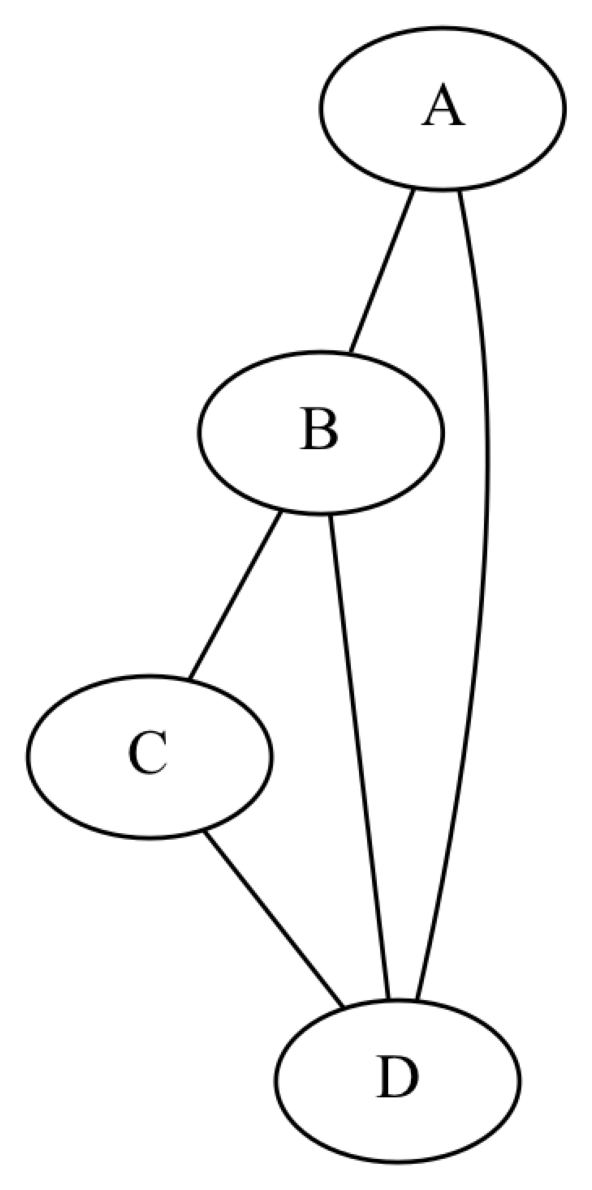

In [14]:
from causallearn.search.ConstraintBased.PC import pc
cg = pc(data)
cg.draw_pydot_graph(labels=labels)


okay interesting so here we see that we have a "faulty' link between B and D and between A and D and that both the link A-B and B-C are not directed 

lets try some other methods and see what happens

okay lets try the same thing but with a larger dataset

In [15]:
def gen_dataset(batch):
    A = np.random.normal(1,1, batch)
    B = vf_b(A)
    C = vf_c(A)
    D =vf_d(C)
    data = np.transpose(np.array([A,B,C,D]))
    return data 

In [16]:
data2 = gen_dataset(1000)
print(data2.shape)

(1000, 4)


  0%|          | 0/4 [00:00<?, ?it/s]

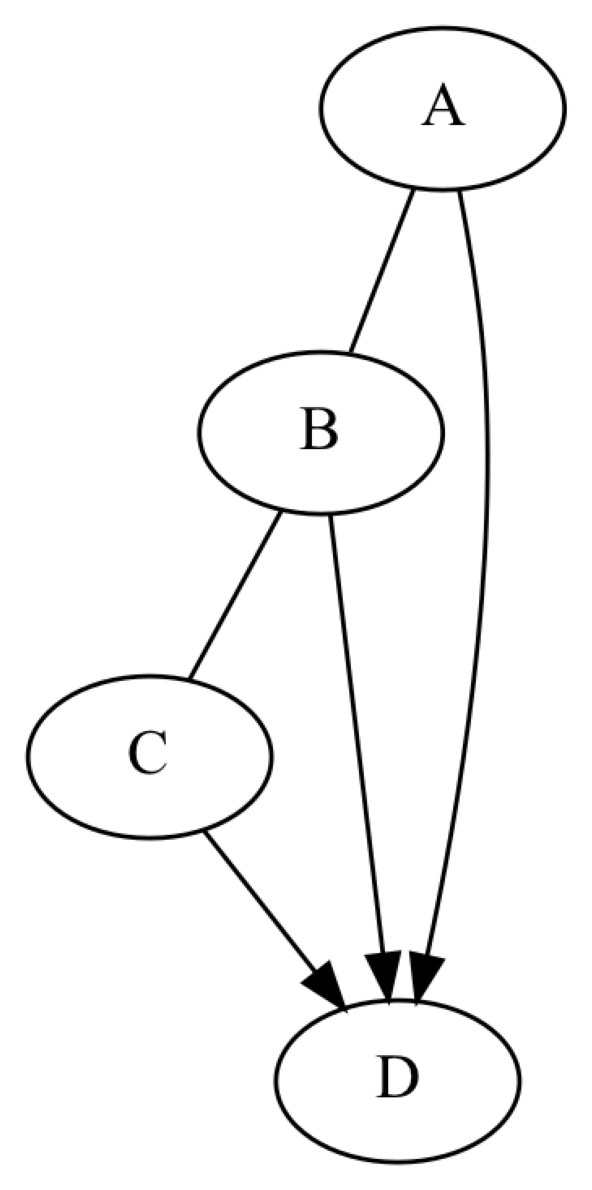

In [17]:
cg2 = pc(data2)

cg2.draw_pydot_graph(labels=labels)

so clearly we get the same graph ... 

In [18]:
cg3 = pc(data2, indep_test="kci")

  0%|          | 0/4 [00:00<?, ?it/s]

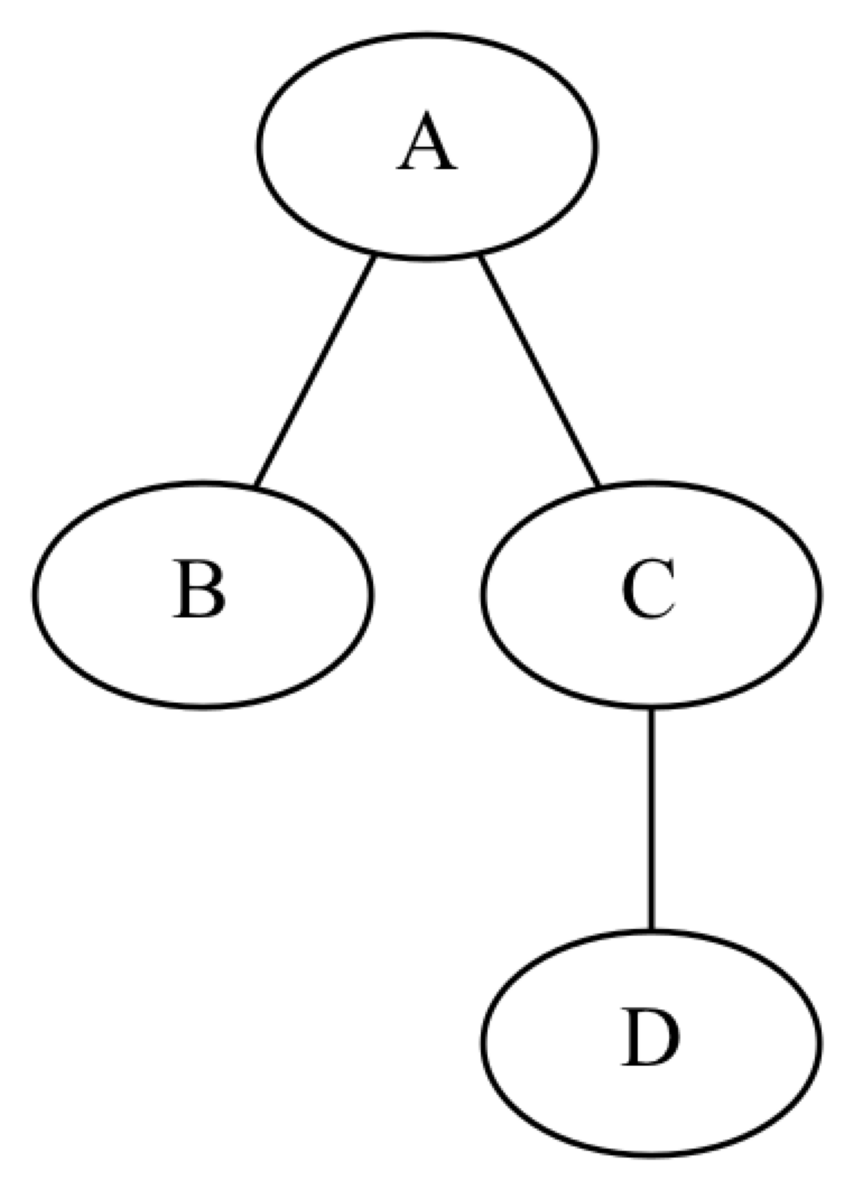

In [19]:
cg3.draw_pydot_graph(labels=labels)

so here we get the correct graph but no directionality, why is that? 

lets try ANM

In [20]:
from causallearn.search.FCMBased.ANM.ANM import ANM 
anm = ANM()
p_forward_ab, p_backward_ab = anm.cause_or_effect(data2[:,0].reshape(-1, 1), data2[:,1].reshape(-1, 1))
# not really sure why but i had to reshape the data 

In [21]:
p_forward_ab > 0.1
print(p_forward_ab)
print(p_backward_ab)

0.58088719944047
0.0


In [22]:
# okay what about downstream a-d
p_forward, p_backward = anm.cause_or_effect(data2[:,0].reshape(-1,1), data2[:,3].reshape(-1,1))
print(p_forward)
print(p_backward)

0.0
0.0


In [23]:
# okay what about downstream a-c
p_forward, p_backward = anm.cause_or_effect(data2[:,0].reshape(-1,1), data2[:,2].reshape(-1,1))
print(p_forward)
print(p_backward)

0.8874868818370196
0.0


In [24]:
# okay what about downstream c-d
p_forward, p_backward = anm.cause_or_effect(data2[:,2].reshape(-1,1), data2[:,3].reshape(-1,1))
print(p_forward)
print(p_backward)

0.012305618938252216
0.0


oh here the p value is super small hmmm 

lets try another method CAMUV


In [27]:
from causallearn.search.FCMBased.lingam import CAMUV

p, u = CAMUV.execute(data2, 0.01, 3)

In [28]:
for i, result in enumerate(p):
    if not len(result) == 0:
        print("child: " + str(i) + ",  parents: "+ str(result))

child: 1,  parents: {0}
child: 2,  parents: {0}
child: 3,  parents: {2}
